# INM701 Coursework
### Aaron Mir (Student Number: 160001207)

In this coursework, you are expected to demonstrate what you have learned in the module by applying artificial intelligence techniques as covered in the module to a dataset and domain of your choice. This will include some or all of:

    • Define the domain and dataset(s) (you are free to choose the domain and the dataset that you want to investigate).

    • Define  questions and analysis tasks (a brief overview  of  the  domain, analytical questions that are being asked, a list of your objectives and the 
    expected output(s)of your analysis)
    
    • Perform an initial investigation of the dataset and the characteristics of the data. Develop a viable plan: which data processing steps you will need to
    perform, how you will transform the data to make it useable, which artificial intelligence techniques you can potentially use and what sorts of potential
    observations these can lead to.

    • Perform the analysis.  Get the data ready for analysis, carry out your analysis/modelling as needed, validate your results and communicate observations, 
    iterating through this process. Analytical operations can include data processing to an extent that is needed (not all datasets are messy) to prepare a useful and
    robust dataset to work within, and data derivation (such as feature engineering).

    • Split your dataset (train/validate/test, somedatasets come pre-split). If you have a holdout test set then you most likely don’t want to use this until the near 
    the end of your work.

    • You might establish a baseline result first, computing metrics on training and validation sets,  analyse  errors, work  on  succeeding iterations, and 
    alternative models. (If initial metrics are amazing and there are no errors is the problem too easy?)

    • Be  close to your data  (visualise  the  dataset,  collect  summary  statistics,  look  at  errors, analyse how different parameters affect performance, try 
    out different model variants).


## Classification of Atrial Fibrillation using a 1D Convolutional Neural Network and Random Forest
Goal: Use the Paroxysmal Atrial Fibrillation Prediction Challenge Database to build a model that can predict onset of Atrial Fibrillation (AF) from an Electrocardiogram (ECG) signal. This database contains a training set (with 50 30-minute two-lead ECGs of patients with Normal Sinus Rhythm (NSR/no signs of AF) and 50 30-minute two-lead ECGs of patients with Paroxysmal AF) and a testing set. The labels of the testing set are not known so in order to test the model, the training set will be split into training and testing sets. 

Extra goal: Use model on other databases


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import scipy
from scipy.signal import filtfilt
from scipy import stats
import itertools
import sklearn
from sklearn import metrics, preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
import keras
import tensorflow.keras.utils
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout, MaxPool1D, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.python.client import device_lib
from keras_sequential_ascii import keras2ascii

In [2]:
print(f"Python: {sys.version}")
print(f"Numpy Version: {np.__version__}")
print(f"Tesorflow Version: {tensorflow.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print(f"Sklearn Version: {sklearn.__version__}")

Python: 3.8.1 (tags/v3.8.1:1b293b6, Dec 18 2019, 23:11:46) [MSC v.1916 64 bit (AMD64)]
Numpy Version: 1.18.1
Tesorflow Version: 2.3.0
Keras Version: 2.4.0
Sklearn Version: 0.23.1


In [3]:
''' DEFINING CONFUSION MATRIX PLOT FUNCTION TAKEN FROM SKLEARN WEBSITE'''
def plot_confusion_matrix(cm, classes, 
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Data Preprocessing and Segmentation

In [4]:
classification = ['NSR', 'AF']
train_folder =  'data/Train'          # data in csv format
numpy_data = 'data/Numpy_Data'        # will contain X_train and y_train data after conversion to np file 

In [5]:
def bandpass_filter(X): # Function to filter the signal between 0.05 and 40Hz to remove baseline wander, motion artifacts, line frequency, respiratory artifacts etc.
    fs = 128.0
    highpass_cutoff = 1.0
    lowpass_cutoff = 40.0

    nyq = 0.5 *fs
    low = highpass_cutoff / nyq
    high = lowpass_cutoff / nyq
    order = 1

    b, a = scipy.signal.butter(order, [low, high], 'bandpass', analog=False)
    x_bp = scipy.signal.filtfilt(b, a, X, axis=0)
    return x_bp

In [6]:
# Each ECG file has 230400 data points and two-leads so two columns per lead and 100 ECG files in total but we want to segment these in order to feed more easily into the model
def load_label_segment(location, length, filtered): 
    X = []
    y = []
    if length == '1 min':
        splitter = 30
    else: splitter = 6
    for i in classification:                                                            # iterate through each type of classification
        for data in os.listdir(location + i):
            df = pd.read_csv(location + i + '\\' + data, names=["ECG1", "ECG2"])        # load the CSV for each file per each classification
            split = np.array_split(df, splitter)                                        # splitting the data into 5 minute lengths to decrease number of convolutions and increase speed 
            for array in split:
                if filtered == True:
                    X.append(np.array(bandpass_filter(array)))
                else: X.append(np.array(array))                              # apply the filter to the ECGs
                if i == 'NSR':                                                          # label data accordingly
                    y.append(0)
                if i == 'AF':
                    y.append(1)    
    return np.array(X), np.expand_dims(np.array(y), axis=1)    

In [17]:
# Load raw ECG training data - for visual comparison below
X_train_raw, y_train_raw = load_label_segment(train_folder, '5 min', False) # '5 min' for 5 minute length segments, '1 min' for 1 minute segments, False for raw ECG, True for Filtered
print(X_train_raw.shape, y_train_raw.shape)

(600, 38400, 2) (600, 1)


In [18]:
# Load normalised/filtered ECG training data - Use 5 min segments for first CNN model, 1 min for second CNN
X_train, y_train = load_label_segment(train_folder, '5 min', True) # '5 min' for 5 minute length segments, '1 min' for 1 minute segments, False for raw ECG, True for Filtered
print(X_train.shape, y_train.shape)

(600, 38400, 2) (600, 1)


In [8]:
np.save('data/Numpy_Data/X_train.npy', X_train) # saving the training data as np files for easy access
np.save('data/Numpy_Data/y_train.npy', y_train)

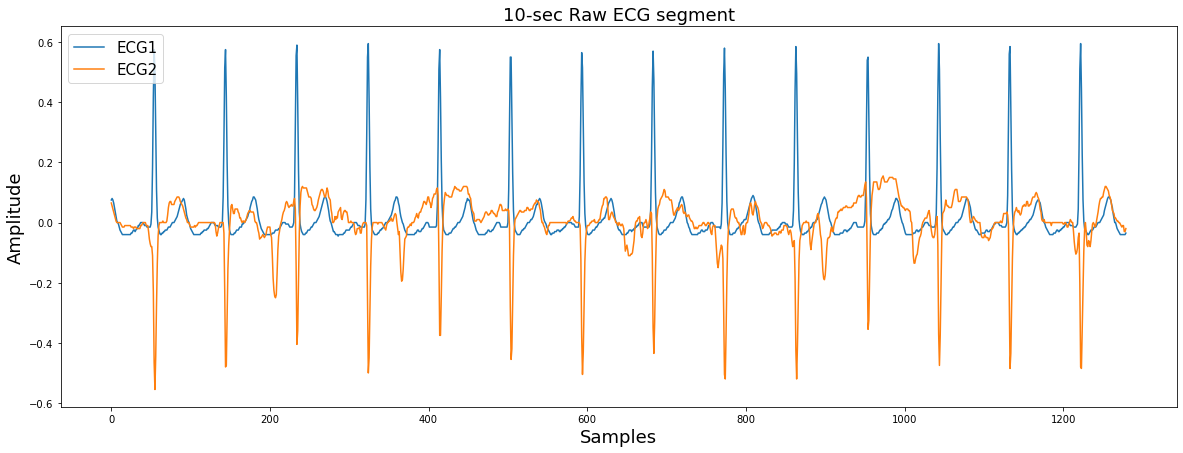

In [19]:
plt.figure(figsize=(20, 7))
plt.plot(X_train_raw[6][1000:2280])  
plt.xlabel('Samples', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)
plt.title('10-sec Raw ECG segment', fontsize=18)
plt.gca().legend(('ECG1','ECG2'), loc="upper left", prop={'size': 15})
#fig.savefig('30-Min Normal ECG.jpg')
plt.show()

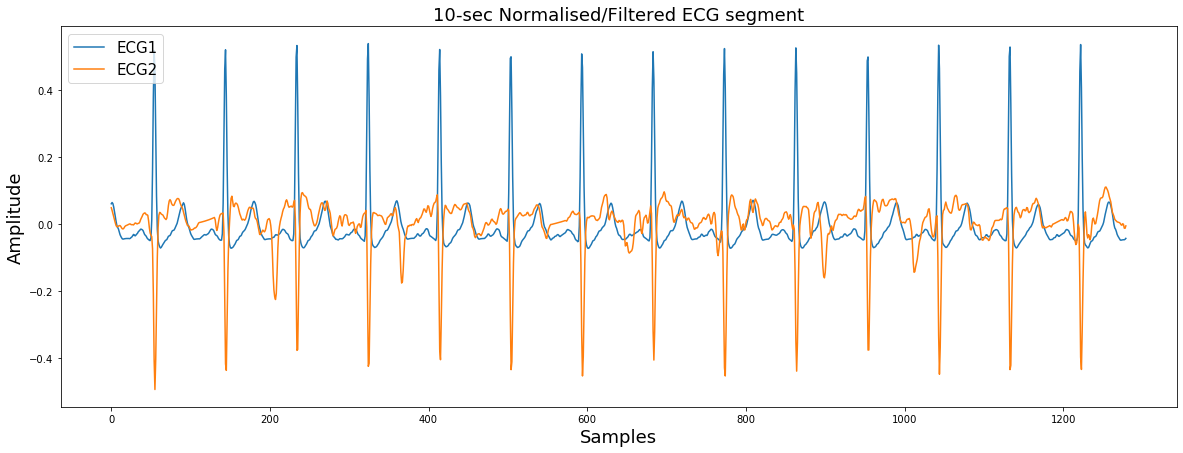

In [20]:
plt.figure(figsize=(20, 7))
plt.plot(X_train[6][1000:2280])
plt.xlabel('Samples', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)
plt.title('10-sec Normalised/Filtered ECG segment', fontsize=18)
plt.gca().legend(('ECG1','ECG2'), loc="upper left", prop={'size': 15})
#fig.savefig('30-Min Normal ECG.jpg')
plt.show()

## 1D Convolutional Neural Network Models
### GPU is available for training the model, IT IS RECOMMENDED TO USE GPU FOR THE MODELS
For the evaluation of the models, the data was split into training, testing and validation sets as seen below. The publicly available dataset is fairly small which is why we segment the data into 5 minute segments. As a result of this, the testing and validation sets are small but I believe it is important to include a validation set in order to validate the training and see if it is overfitting, underfitting etc.

In [25]:
device_lib.list_local_devices(); 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=1)  
#70/30 train/test split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
#75/25 train/val split 

In [22]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(315, 38400, 2) (315, 1)
(180, 38400, 2) (180, 1)
(105, 38400, 2) (105, 1)


# Configuration 1 - WORKS WELL - IS SMALL AND FAST - USES 5 MINUTE ECG SEGMENTS AS INPUT - BASELINE MODEL

In [64]:
# input, convolutional, subsampling(maxpool), fully connected and output
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=32, padding = 'same', kernel_initializer='normal', activation='relu', input_shape=(38400, 2)))                 # Conv layer - 5 minute ECG input
model.add(MaxPool1D(pool_size=32))                                                                                                                      # Subsampling layer
model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))                                                                              # Dense layer
model.add(MaxPool1D(pool_size=64))                                                                                                                      # Subsampling layer
model.add(Flatten())                                                                                                                                    # Flatten
model.add(Dense(units=1, kernel_initializer='normal', activation='sigmoid'))                                                                            # Sigmoid output, better than softmax
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 38400, 64)         4160      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1200, 64)          0         
_________________________________________________________________
dense_16 (Dense)             (None, 1200, 32)          2080      
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 18, 32)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 577       
Total params: 6,817
Trainable params: 6,817
Non-trainable params: 0
____________________________________________________

## Adam works well - Learning rate 0.0001 - Takes very long for loss to even out - slight overfitting

In [50]:
optimizer = keras.optimizers.Adam(lr=0.0001) 
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(X_train, y_train, batch_size=64, epochs=200, validation_data=(X_val,y_val), callbacks=[es])

Epoch 1/200
5/5 [==============================] - 1s 189ms/step - loss: 0.6975 - accuracy: 0.4921 - val_loss: 0.6954 - val_accuracy: 0.5143
Epoch 2/200
5/5 [==============================] - 1s 146ms/step - loss: 0.6943 - accuracy: 0.4921 - val_loss: 0.6926 - val_accuracy: 0.5143
Epoch 3/200
5/5 [==============================] - 1s 148ms/step - loss: 0.6914 - accuracy: 0.4921 - val_loss: 0.6906 - val_accuracy: 0.5143
Epoch 4/200
5/5 [==============================] - 1s 153ms/step - loss: 0.6892 - accuracy: 0.4921 - val_loss: 0.6889 - val_accuracy: 0.5143
Epoch 5/200
5/5 [==============================] - 1s 149ms/step - loss: 0.6876 - accuracy: 0.4921 - val_loss: 0.6872 - val_accuracy: 0.5143
Epoch 6/200
5/5 [==============================] - 1s 148ms/step - loss: 0.6856 - accuracy: 0.5143 - val_loss: 0.6857 - val_accuracy: 0.5524
Epoch 7/200
5/5 [==============================] - 1s 140ms/step - loss: 0.6839 - accuracy: 0.5746 - val_loss: 0.6842 - val_accuracy: 0.6000
Epoch 8/200
5

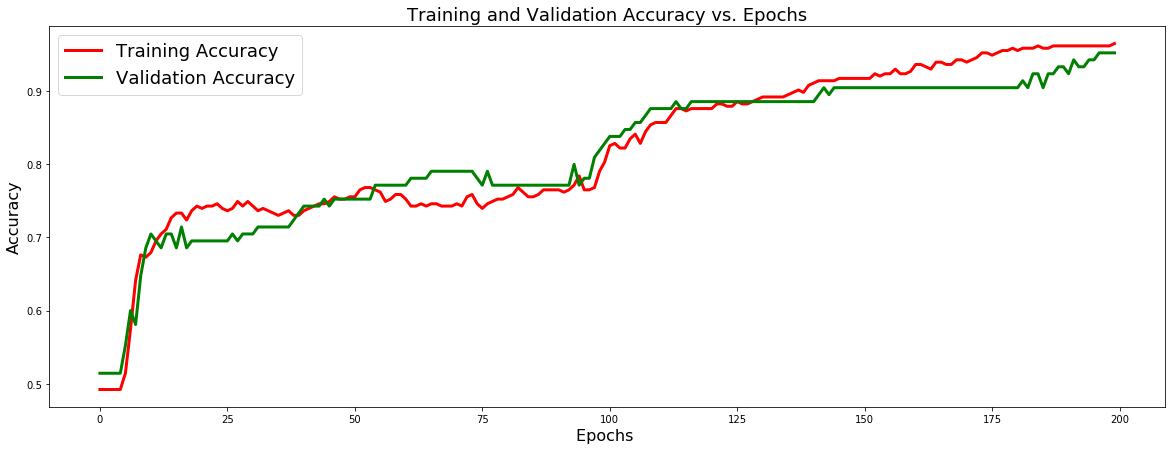

In [51]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

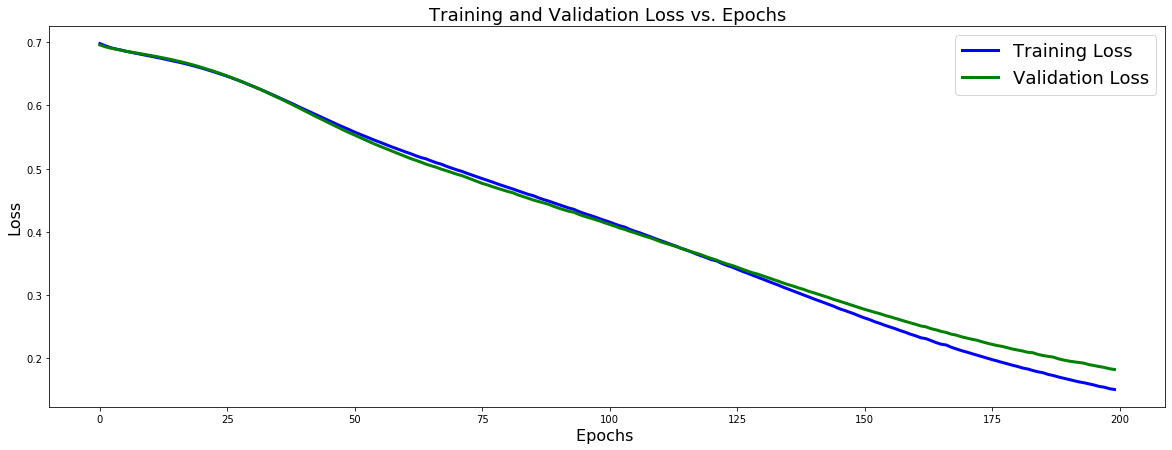

In [52]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

## Adam - Learning rate 0.001 - slight overfitting

In [65]:
optimizer = keras.optimizers.Adam(lr=0.001) 
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_val,y_val), callbacks=[es])

Epoch 1/50
5/5 [==============================] - 1s 176ms/step - loss: 0.6873 - accuracy: 0.5143 - val_loss: 0.6736 - val_accuracy: 0.5333
Epoch 2/50
5/5 [==============================] - 1s 144ms/step - loss: 0.6641 - accuracy: 0.6381 - val_loss: 0.6486 - val_accuracy: 0.6667
Epoch 3/50
5/5 [==============================] - 1s 144ms/step - loss: 0.6392 - accuracy: 0.6667 - val_loss: 0.6178 - val_accuracy: 0.7048
Epoch 4/50
5/5 [==============================] - 1s 139ms/step - loss: 0.6100 - accuracy: 0.6889 - val_loss: 0.5807 - val_accuracy: 0.7429
Epoch 5/50
5/5 [==============================] - 1s 124ms/step - loss: 0.5791 - accuracy: 0.6921 - val_loss: 0.5451 - val_accuracy: 0.7238
Epoch 6/50
5/5 [==============================] - 1s 120ms/step - loss: 0.5500 - accuracy: 0.6952 - val_loss: 0.5156 - val_accuracy: 0.7429
Epoch 7/50
5/5 [==============================] - 1s 121ms/step - loss: 0.5242 - accuracy: 0.7175 - val_loss: 0.4904 - val_accuracy: 0.7524
Epoch 8/50
5/5 [====

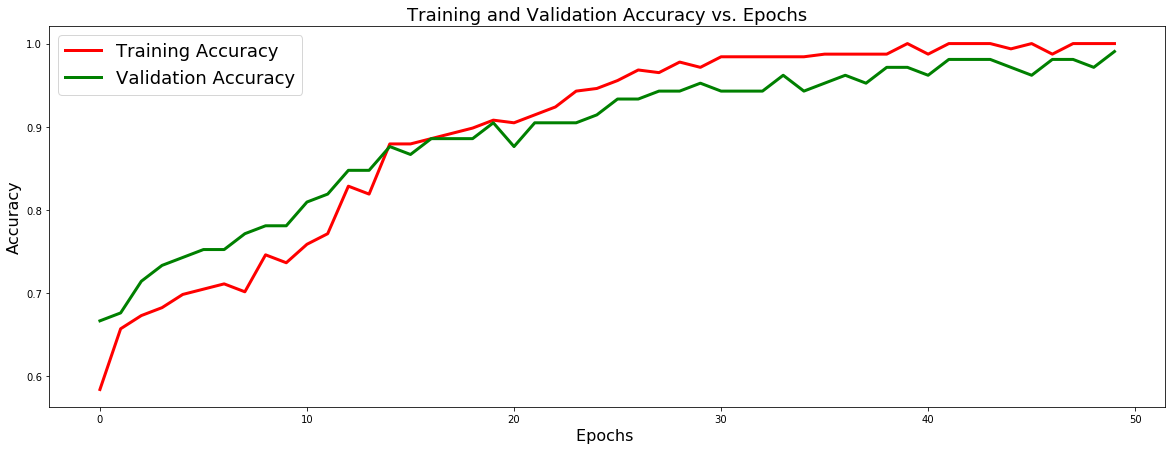

In [55]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

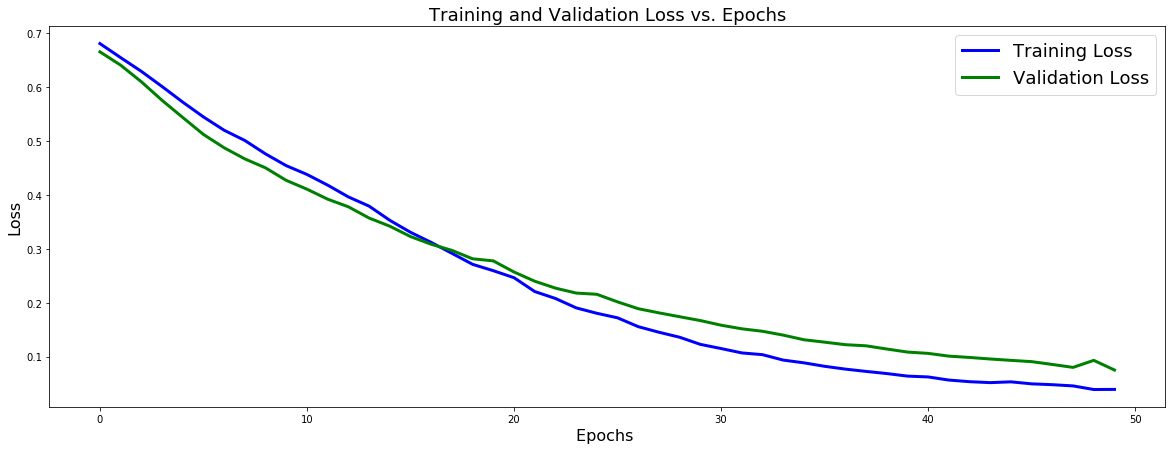

In [56]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

## Trying LR 0.001 again to verify

In [60]:
optimizer = keras.optimizers.Adam(lr=0.001) 
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_val,y_val), callbacks=[es])

Epoch 1/50
5/5 [==============================] - 1s 177ms/step - loss: 0.6929 - accuracy: 0.4762 - val_loss: 0.6807 - val_accuracy: 0.4857
Epoch 2/50
5/5 [==============================] - 1s 137ms/step - loss: 0.6724 - accuracy: 0.6190 - val_loss: 0.6652 - val_accuracy: 0.6571
Epoch 3/50
5/5 [==============================] - 1s 127ms/step - loss: 0.6590 - accuracy: 0.6317 - val_loss: 0.6472 - val_accuracy: 0.6762
Epoch 4/50
5/5 [==============================] - 1s 123ms/step - loss: 0.6397 - accuracy: 0.6603 - val_loss: 0.6243 - val_accuracy: 0.7429
Epoch 5/50
5/5 [==============================] - 1s 126ms/step - loss: 0.6175 - accuracy: 0.6921 - val_loss: 0.5954 - val_accuracy: 0.7429
Epoch 6/50
5/5 [==============================] - 1s 124ms/step - loss: 0.5937 - accuracy: 0.6921 - val_loss: 0.5657 - val_accuracy: 0.7429
Epoch 7/50
5/5 [==============================] - 1s 120ms/step - loss: 0.5716 - accuracy: 0.6984 - val_loss: 0.5424 - val_accuracy: 0.7429
Epoch 8/50
5/5 [====

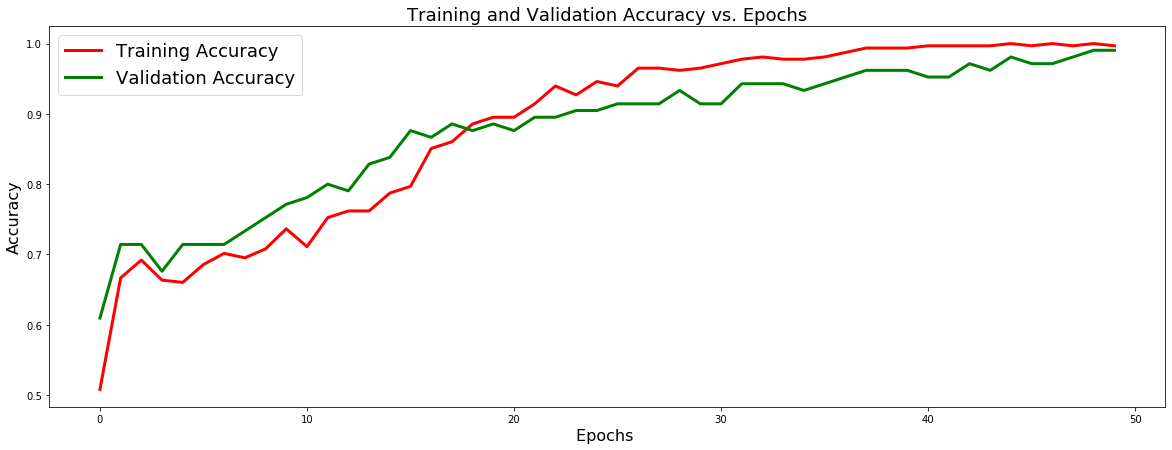

In [86]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

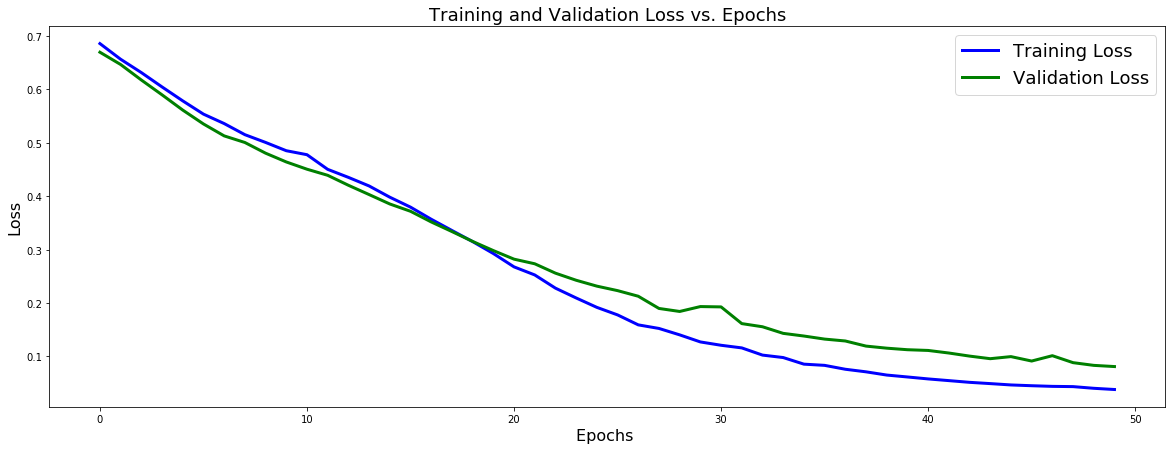

In [87]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

## Learning rate 0.0005 - long time for loss to even out

In [176]:
optimizer = keras.optimizers.Adam(lr=0.0005) 
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_val,y_val), callbacks=[es])

Epoch 1/70
3/3 [==============================] - 1s 294ms/step - loss: 0.6956 - accuracy: 0.4881 - val_loss: 0.6919 - val_accuracy: 0.5119
Epoch 2/70
3/3 [==============================] - 1s 230ms/step - loss: 0.6879 - accuracy: 0.5595 - val_loss: 0.6868 - val_accuracy: 0.5476
Epoch 3/70
3/3 [==============================] - 1s 227ms/step - loss: 0.6821 - accuracy: 0.6220 - val_loss: 0.6823 - val_accuracy: 0.6310
Epoch 4/70
3/3 [==============================] - 1s 229ms/step - loss: 0.6768 - accuracy: 0.6518 - val_loss: 0.6780 - val_accuracy: 0.6429
Epoch 5/70
3/3 [==============================] - 1s 231ms/step - loss: 0.6710 - accuracy: 0.6756 - val_loss: 0.6739 - val_accuracy: 0.6786
Epoch 6/70
3/3 [==============================] - 1s 228ms/step - loss: 0.6653 - accuracy: 0.6935 - val_loss: 0.6695 - val_accuracy: 0.6905
Epoch 7/70
3/3 [==============================] - 1s 227ms/step - loss: 0.6591 - accuracy: 0.7173 - val_loss: 0.6645 - val_accuracy: 0.7024
Epoch 8/70
3/3 [====

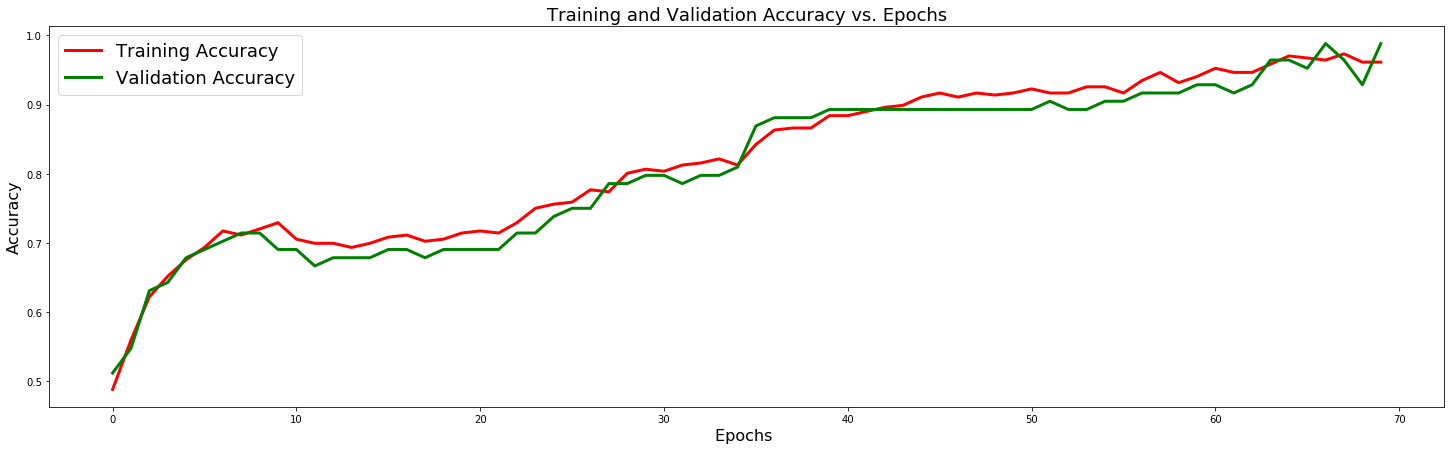

In [177]:
plt.figure(figsize=(25, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

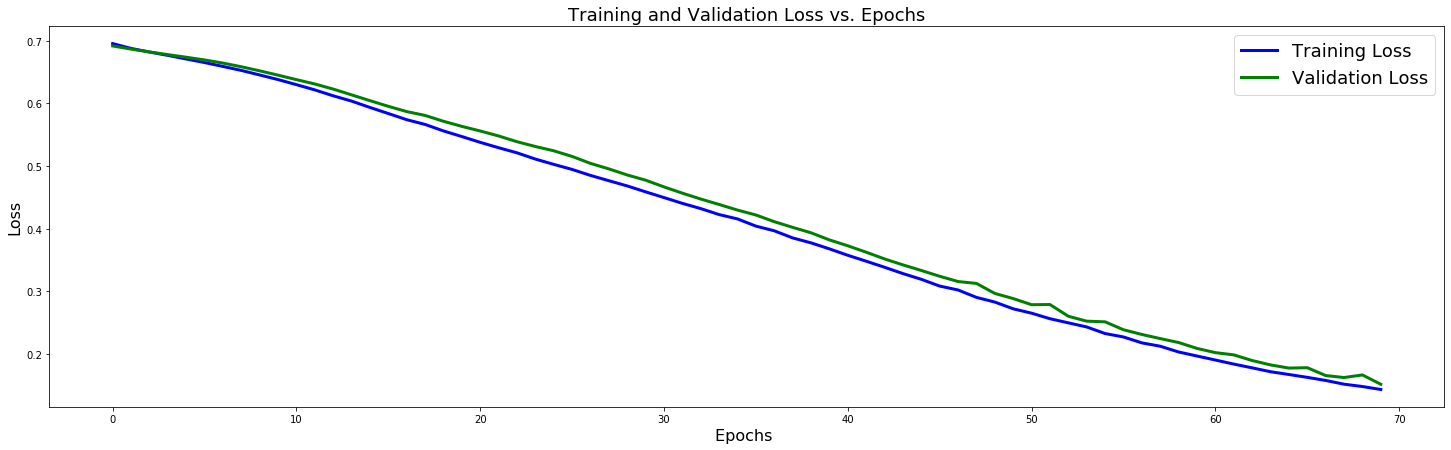

In [178]:
plt.figure(figsize=(25, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

## SGD - not so bad either but Adam is better - slight overfitting

In [78]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9) 
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history3 = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_val,y_val), callbacks=[es])

Epoch 1/60
5/5 [==============================] - 1s 208ms/step - loss: 0.6918 - accuracy: 0.5619 - val_loss: 0.6896 - val_accuracy: 0.5905
Epoch 2/60
5/5 [==============================] - 1s 167ms/step - loss: 0.6897 - accuracy: 0.6222 - val_loss: 0.6878 - val_accuracy: 0.6000
Epoch 3/60
5/5 [==============================] - 1s 162ms/step - loss: 0.6866 - accuracy: 0.6222 - val_loss: 0.6851 - val_accuracy: 0.5619
Epoch 4/60
5/5 [==============================] - 1s 162ms/step - loss: 0.6829 - accuracy: 0.5968 - val_loss: 0.6819 - val_accuracy: 0.5238
Epoch 5/60
5/5 [==============================] - 1s 160ms/step - loss: 0.6788 - accuracy: 0.5905 - val_loss: 0.6772 - val_accuracy: 0.5333
Epoch 6/60
5/5 [==============================] - 1s 181ms/step - loss: 0.6729 - accuracy: 0.5968 - val_loss: 0.6708 - val_accuracy: 0.5524
Epoch 7/60
5/5 [==============================] - 1s 153ms/step - loss: 0.6667 - accuracy: 0.6635 - val_loss: 0.6615 - val_accuracy: 0.6952
Epoch 8/60
5/5 [====

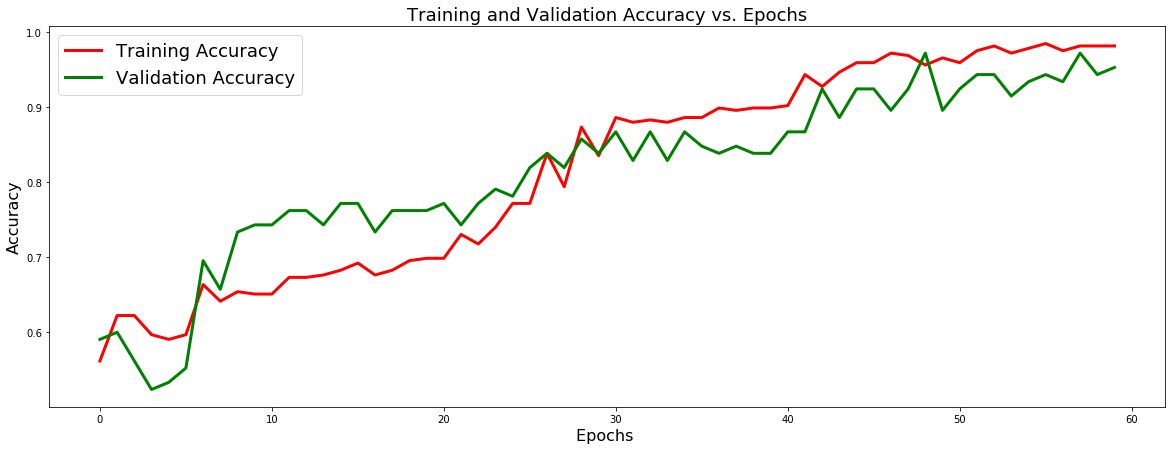

In [79]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs', fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

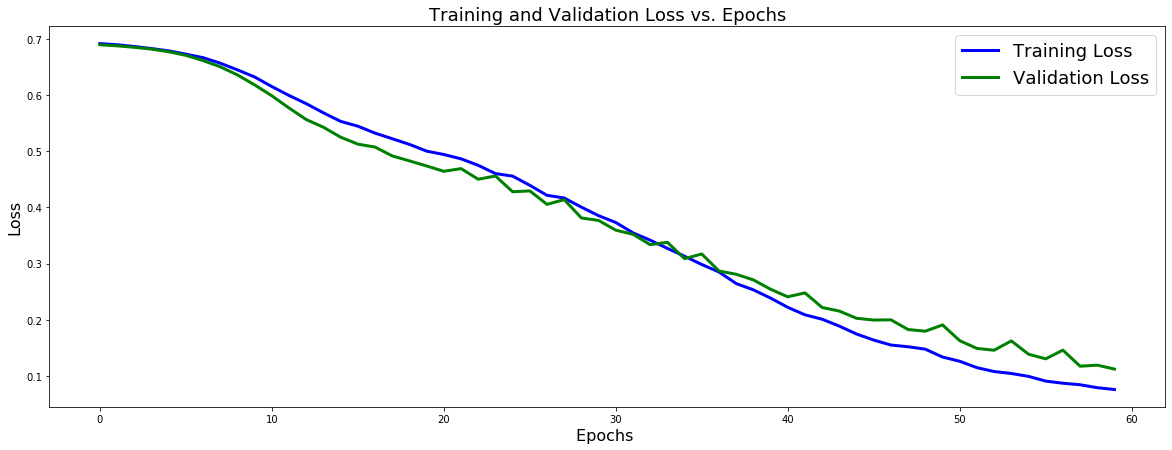

In [80]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs', fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

## Evaluating on the model using Adam with LR = 0.001

In [81]:
y_pred_train = model.predict(x=X_train, batch_size=64)

In [70]:
y_pred = model.predict(x=X_test, batch_size=64)

In [71]:
y_pred = np.round(y_pred)
print(y_pred.shape)

(180, 1)


In [82]:
y_pred_train = np.round(y_pred_train)
print(y_pred_train.shape)

(315, 1)


In [72]:
np.count_nonzero(y_pred == 1)

94

In [83]:
np.count_nonzero(y_pred_train == 1)

155

In [73]:
for i in range(20):
	print("Predicted=%s, Actual=%s" % (y_pred[i], y_test[i]))

Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]


In [84]:
accuracy_train = Accuracy()                           # Training accuracy
accuracy_train.update_state(y_train, y_pred_train)
accuracy_train.result().numpy()

1.0

In [74]:
accuracy = Accuracy()
accuracy.update_state(y_test, y_pred)
accuracy.result().numpy()

0.98333335

In [75]:
calculated_accuracy = sum(y_pred == y_test)/len(y_pred)
print(calculated_accuracy)

[0.98333333]


In [76]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

Confusion matrix, without normalization
[[86  3]
 [ 0 91]]


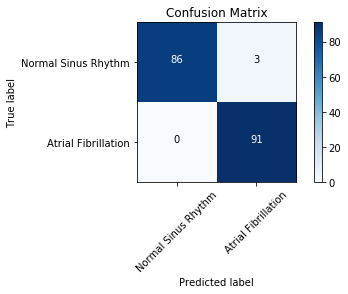

In [77]:
cm_plot_labels = ['Normal Sinus Rhythm', 'Atrial Fibrillation']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')

In [80]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        89
           1       0.97      1.00      0.98        91

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



In [78]:
model_path = os.path.join('models', 'CNN2-Small')
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models\CNN2-Small\assets
Saved trained model at models\CNN2-Small 


# Another Configuration - ONLY WORKS WELL WITH 1 MINUTE ECG SEGMENTS, NOT 5 LIKE THE OTHER MODEL - ALSO REQUIRES MORE PROCESSING POWER 

In [9]:
# Load normalised/filtered ECG training data - Use 5 min segments for first CNN model, 1 min for second CNN
X_train, y_train = load_label_segment(train_folder, '1 min', True) # '5 min' for 5 minute length segments, '1 min' for 1 minute segments, False for raw ECG, True for Filtered
print(X_train.shape, y_train.shape)

(3000, 7680, 2) (3000, 1)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=30)  
#70/30 train/test split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=30)
#75/25 train/val split 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(1575, 7680, 2) (1575, 1)
(900, 7680, 2) (900, 1)
(525, 7680, 2) (525, 1)


In [34]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu', input_shape=(7680, 2))) # Conv layer taking 1 minute segments input 7680
model.add(BatchNormalization())                                                                                                       # Adding normalisation
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Conv1D(filters=32, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                        # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Conv1D(filters=64, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                        # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Conv1D(filters=128, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                       # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Conv1D(filters=128, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                       # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Dropout(0.5))                                                                                                               # Dropout, prevents overfitting (50%)
model.add(Conv1D(filters=256, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                       # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Conv1D(filters=256, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                       # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Dropout(0.5))                                                                                                               # Dropout (50%)
model.add(Conv1D(filters=512, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                       # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Dropout(0.5))                                                                                                               # Dropout (50%)
model.add(Conv1D(filters=512, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                       # Conv layer
model.add(Flatten())                                                                                                                  # Flatten
model.add(Dense(units=128, kernel_initializer='normal', activation='relu'))                                                           # FC Layer, 128 neurons
model.add(Dropout(0.5))                                                                                                               # Dropout (50%)
model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))                                                            # FC layer, 32 neurons
model.add(Dense(units=1, kernel_initializer='normal', activation='sigmoid'))                                                          # Output layer, binary classification
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 7680, 32)          352       
_________________________________________________________________
batch_normalization_1 (Batch (None, 7680, 32)          128       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 3840, 32)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 3840, 32)          5152      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 1920, 32)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1920, 64)          10304     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 960, 64)          

## TRYING WITH SGD OPTIMIZER - Not great

In [148]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9) #0.005/30 0.01/65
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history3 = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val,y_val), callbacks=[es])

Epoch 1/90
25/25 [==============================] - 2s 93ms/step - loss: 0.7459 - accuracy: 0.4946 - val_loss: 0.6933 - val_accuracy: 0.4876
Epoch 2/90
25/25 [==============================] - 2s 79ms/step - loss: 0.7051 - accuracy: 0.5010 - val_loss: 0.6933 - val_accuracy: 0.4876
Epoch 3/90
25/25 [==============================] - 2s 79ms/step - loss: 0.6970 - accuracy: 0.4857 - val_loss: 0.6933 - val_accuracy: 0.4876
Epoch 4/90
25/25 [==============================] - 2s 79ms/step - loss: 0.6954 - accuracy: 0.5022 - val_loss: 0.6933 - val_accuracy: 0.4876
Epoch 5/90
25/25 [==============================] - 2s 79ms/step - loss: 0.6992 - accuracy: 0.4946 - val_loss: 0.6934 - val_accuracy: 0.4895
Epoch 6/90
25/25 [==============================] - 2s 79ms/step - loss: 0.6955 - accuracy: 0.4660 - val_loss: 0.6934 - val_accuracy: 0.4876
Epoch 7/90
25/25 [==============================] - 2s 80ms/step - loss: 0.6946 - accuracy: 0.5003 - val_loss: 0.6935 - val_accuracy: 0.4876
Epoch 8/90
25

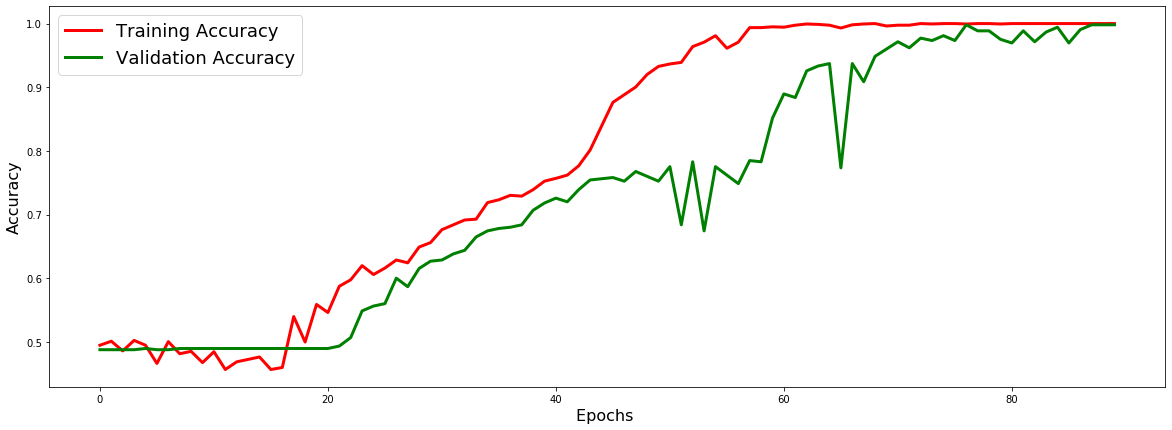

In [149]:
plt.figure(figsize=(20, 7))
plt.plot(history3.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

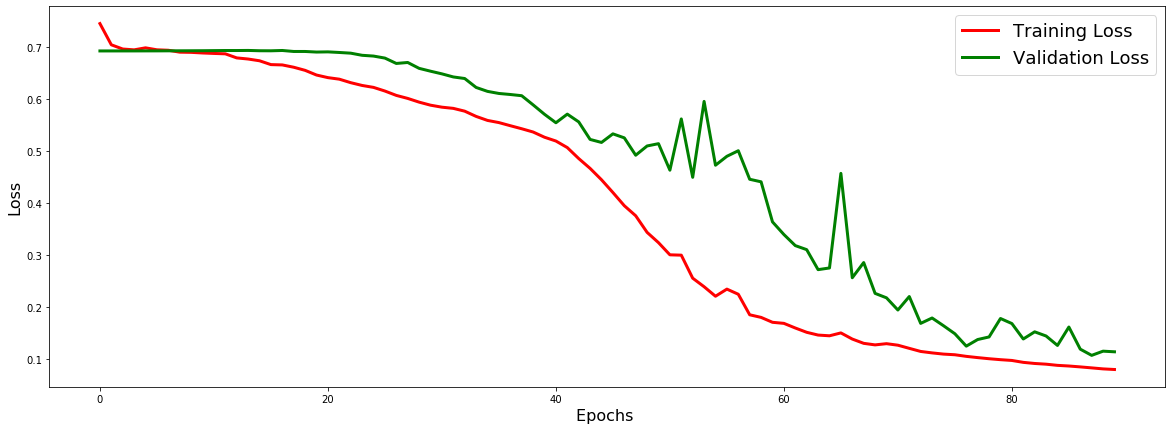

In [150]:
plt.figure(figsize=(20, 7))
plt.plot(history3.history['loss'], 'r', linewidth=3.0, label='Training Loss')
plt.plot(history3.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=18)
plt.show()

## TRYING ADAM - LR = 0.0001 - better

In [134]:
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history4 = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_val,y_val), callbacks=[es]) 

Epoch 1/25
25/25 [==============================] - 2s 94ms/step - loss: 0.7817 - accuracy: 0.5117 - val_loss: 0.6931 - val_accuracy: 0.4914
Epoch 2/25
25/25 [==============================] - 2s 79ms/step - loss: 0.6961 - accuracy: 0.5314 - val_loss: 0.6928 - val_accuracy: 0.6076
Epoch 3/25
25/25 [==============================] - 2s 79ms/step - loss: 0.7028 - accuracy: 0.4787 - val_loss: 0.6928 - val_accuracy: 0.5352
Epoch 4/25
25/25 [==============================] - 2s 78ms/step - loss: 0.6910 - accuracy: 0.4940 - val_loss: 0.6928 - val_accuracy: 0.4933
Epoch 5/25
25/25 [==============================] - 2s 70ms/step - loss: 0.6852 - accuracy: 0.4990 - val_loss: 0.6927 - val_accuracy: 0.4914
Epoch 6/25
25/25 [==============================] - 2s 73ms/step - loss: 0.6861 - accuracy: 0.4908 - val_loss: 0.6926 - val_accuracy: 0.4914
Epoch 7/25
25/25 [==============================] - 2s 71ms/step - loss: 0.6778 - accuracy: 0.4952 - val_loss: 0.6922 - val_accuracy: 0.5295
Epoch 8/25
25

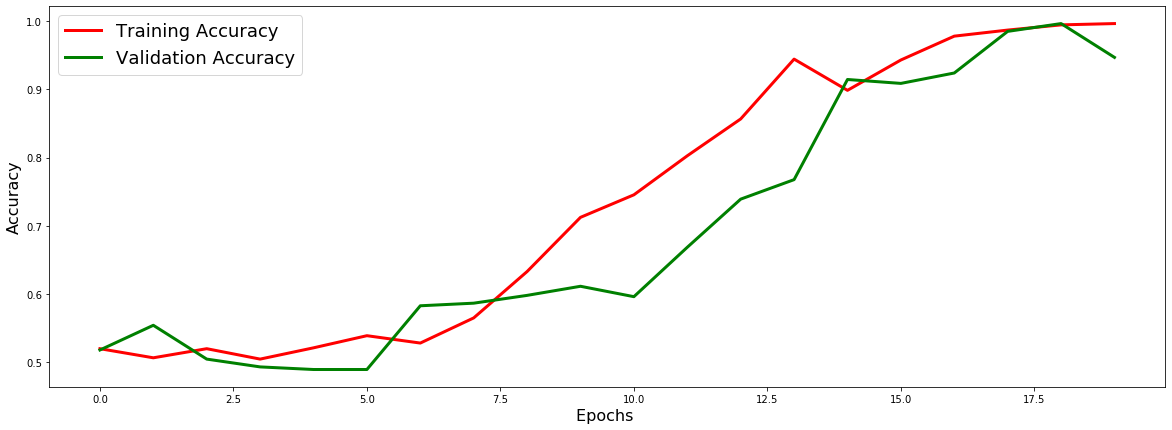

In [211]:
plt.figure(figsize=(20, 7))
plt.plot(history4.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

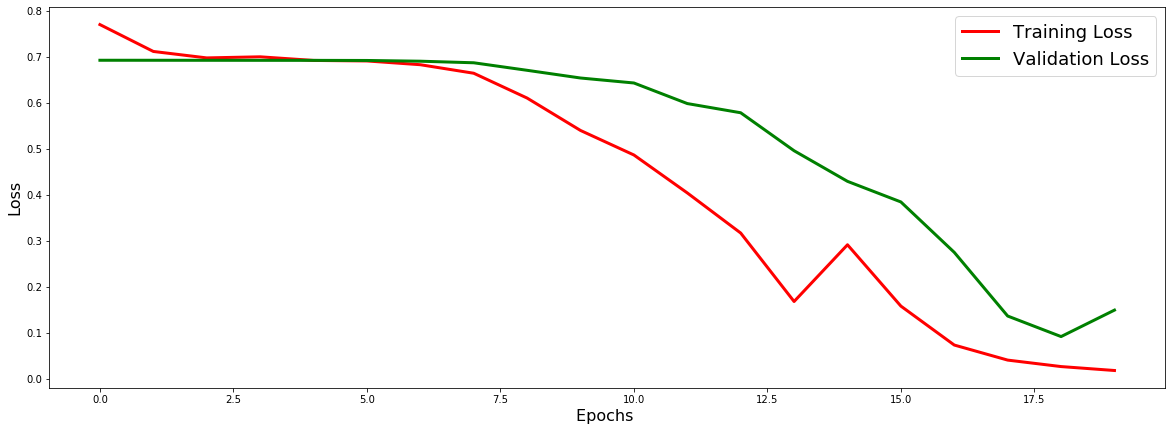

In [212]:
plt.figure(figsize=(20, 7))
plt.plot(history4.history['loss'], 'r', linewidth=3.0, label='Training Loss')
plt.plot(history4.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=18)
plt.show()

## Trying Adam again with LR=0.0001

In [35]:
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history4 = model.fit(X_train, y_train, batch_size=64, epochs=30, validation_data=(X_val,y_val), callbacks=[es]) 

Epoch 1/30
25/25 [==============================] - 2s 90ms/step - loss: 0.7809 - accuracy: 0.5022 - val_loss: 0.6931 - val_accuracy: 0.5448
Epoch 2/30
25/25 [==============================] - 2s 77ms/step - loss: 0.7079 - accuracy: 0.4857 - val_loss: 0.6931 - val_accuracy: 0.4857
Epoch 3/30
25/25 [==============================] - 2s 77ms/step - loss: 0.6998 - accuracy: 0.4952 - val_loss: 0.6931 - val_accuracy: 0.4876
Epoch 4/30
25/25 [==============================] - 2s 78ms/step - loss: 0.6956 - accuracy: 0.5105 - val_loss: 0.6931 - val_accuracy: 0.4895
Epoch 5/30
25/25 [==============================] - 2s 77ms/step - loss: 0.6925 - accuracy: 0.5283 - val_loss: 0.6930 - val_accuracy: 0.4933
Epoch 6/30
25/25 [==============================] - 2s 78ms/step - loss: 0.6924 - accuracy: 0.5137 - val_loss: 0.6930 - val_accuracy: 0.4914
Epoch 7/30
25/25 [==============================] - 2s 78ms/step - loss: 0.6960 - accuracy: 0.4857 - val_loss: 0.6930 - val_accuracy: 0.4876
Epoch 8/30
25

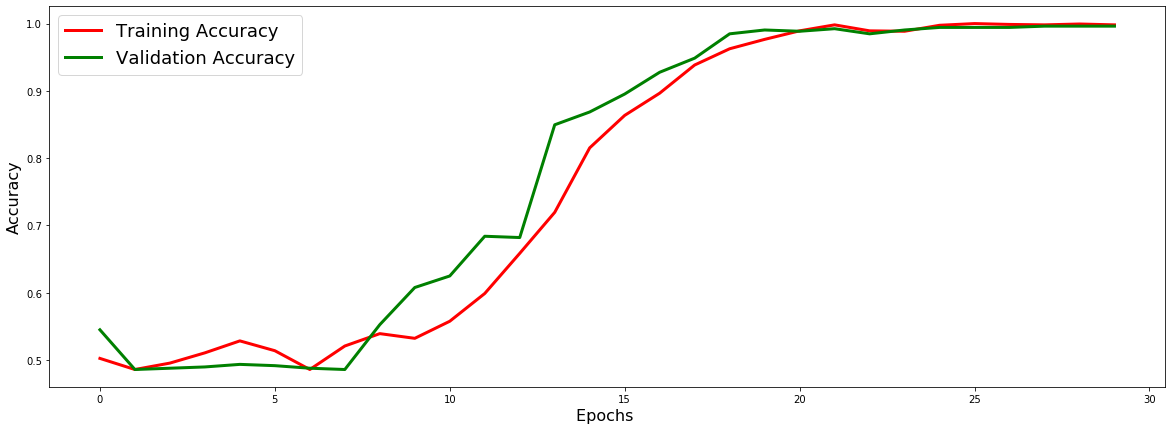

In [36]:
plt.figure(figsize=(20, 7))
plt.plot(history4.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

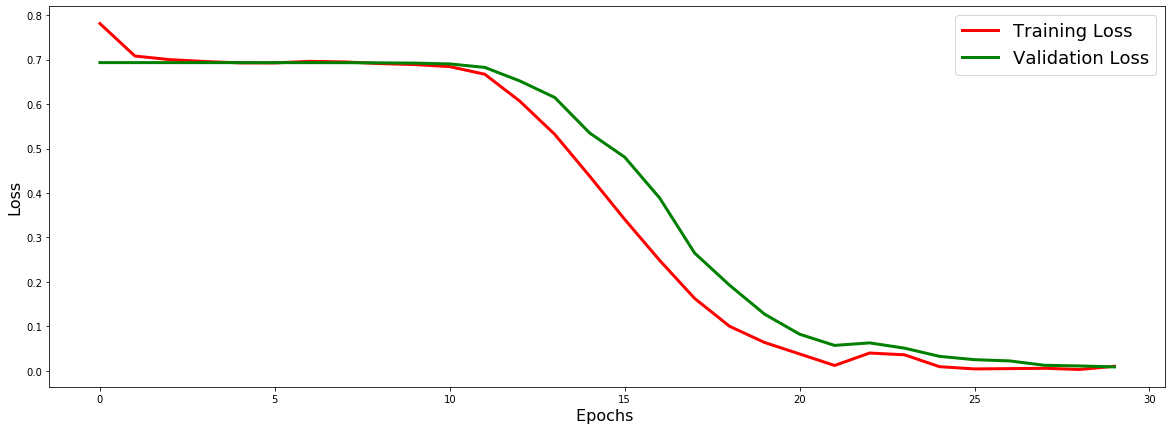

In [37]:
plt.figure(figsize=(20, 7))
plt.plot(history4.history['loss'], 'r', linewidth=3.0, label='Training Loss')
plt.plot(history4.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=18)
plt.show()

## Evaluating using Adam at LR= 0.0001

In [38]:
y_pred = model.predict(x=X_test, batch_size=64)

In [39]:
y_pred = np.round(y_pred)

In [40]:
np.count_nonzero(y_pred == 0)

449

In [41]:
for i in range(20):
	print("Predicted=%s, Actual=%s" % (y_pred[i], y_test[i]))

Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]


In [42]:
accuracy = Accuracy()
accuracy.update_state(y_test, y_pred)
accuracy.result().numpy()

0.99777776

In [43]:
calculated_accuracy = sum(y_pred == y_test)/len(y_pred)
print(calculated_accuracy)

[0.99777778]


In [44]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

Confusion matrix, without normalization
[[449   2]
 [  0 449]]


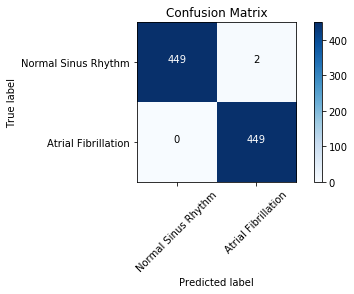

In [45]:
cm_plot_labels = ['Normal Sinus Rhythm', 'Atrial Fibrillation']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')

In [46]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       451
           1       1.00      1.00      1.00       449

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



In [121]:
model_path = os.path.join('models', 'CNN1')
model.save(model_path)
print('Saved trained model at %s ' % model_path)

INFO:tensorflow:Assets written to: models\CNN1\assets
Saved trained model at models\CNN1 


## Extra Trees Classifier (Randomised Decision Trees)

In [47]:
# Load normalised/filtered ECG training data - Use 5 min segments for first CNN model, 1 min for second CNN
X_train, y_train = load_label_segment(train_folder, '5 min', True) # '5 min' for 5 minute length segments, '1 min' for 1 minute segments, False for raw ECG, True for Filtered
print(X_train.shape, y_train.shape)

(600, 38400, 2) (600, 1)


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=30)

In [49]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(480, 38400, 2) (480, 1)
(120, 38400, 2) (120, 1)


In [50]:
n_samples_train, n_x_train, n_y_train = X_train.shape

In [51]:
X_train_2D = X_train.reshape((n_samples_train,n_x_train*n_y_train))
print(X_train_2D.shape)

(480, 76800)


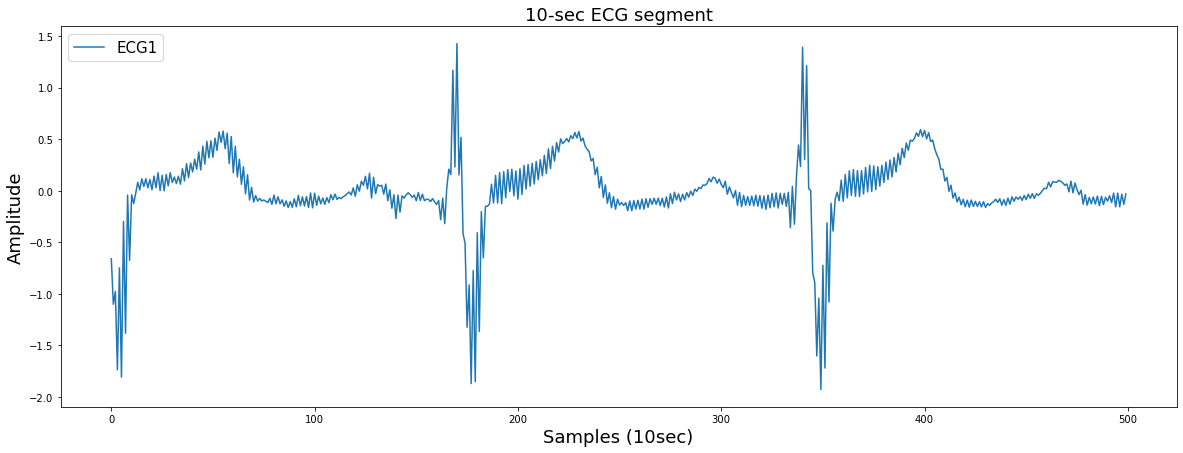

In [52]:
plt.figure(figsize=(20, 7))
plt.plot(X_train_2D[1][1000:1500]) # 
plt.xlabel('Samples (10sec)', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)
plt.title('10-sec ECG segment', fontsize=18)
plt.gca().legend(('ECG1','ECG2'), loc="upper left", prop={'size': 15})
#fig.savefig('30-Min Normal ECG.jpg')
plt.show()

In [53]:
extratree = ExtraTreesClassifier(n_estimators=100, criterion='gini', random_state=30)

In [54]:
extratree.fit(X_train_2D, y_train)

ExtraTreesClassifier(random_state=30)

In [55]:
n_samples_test, n_x_test, n_y_test = X_test.shape

In [56]:
X_test_2D = X_test.reshape(( n_samples_test, n_x_test*n_y_test ))

In [57]:
print(X_test_2D.shape)

(120, 76800)


In [58]:
y_test[3]

array([1])

In [59]:
y_pred_extra_tree = extratree.predict(X_test_2D)

In [60]:
acc_extra_tree = extratree.score(X_test_2D, y_test)
print(acc_extra_tree)

0.7333333333333333


In [61]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_extra_tree)

Confusion matrix, without normalization
[[46 15]
 [17 42]]


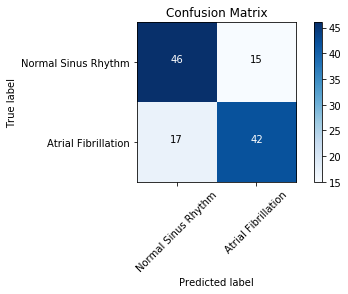

In [62]:
cm_plot_labels = ['Normal Sinus Rhythm', 'Atrial Fibrillation']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')

In [64]:
print(classification_report(y_true=y_test, y_pred=y_pred_extra_tree))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74        61
           1       0.74      0.71      0.72        59

    accuracy                           0.73       120
   macro avg       0.73      0.73      0.73       120
weighted avg       0.73      0.73      0.73       120

